## **1. Installation and imports**

In [1]:
import os
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

# Imports for the probing model
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# Import for the model
from transformers import BertTokenizer, BertForSequenceClassification
from src.config import load_config
from src.model import PatentSentenceClassifier

## **2. Loading the model**

In [2]:
# Load Config
cfg = load_config('config.yaml')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load Tokenizer and Base Model
bert_tokenizer = BertTokenizer.from_pretrained(cfg.model.name)
base_model = BertForSequenceClassification.from_pretrained(cfg.model.name, num_labels=cfg.model.num_lables, output_hidden_states=True)
base_model.to(device)
print('\nTokenizer and Base Model loaded succesfully.')

# Load Finetuned Patent Model
#checkpoint_path = '/home/fantoni/patent-sentence-classification/models/best-checkpoint_stratified.ckpt'
#loaded_model = PatentSentenceClassifier.load_from_checkpoint(checkpoint_path, model=base_model, tokenizer=bert_tokenizer)
#loaded_model.eval()
#loaded_model.to(device)
#print('\nModel loaded succesfully.')

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer and Base Model loaded succesfully.


## **3. Dataset**

In [3]:
# Import test set
df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/test.xlsx')
print(f"Tot. number of sentences: {len(df)}")
df.head(10)

Tot. number of sentences: 601


,sent_id,sent,sent_tag,sent_class
0,2534415,"However, the described techniques may be imple...",FUN,0
1,1930270,The louvers 138 are operable to pivot upward a...,FUN,0
2,2600702,"In the depictions in figures 2 and 9-12, the p...",STR,1
3,1847580,The sensor component 814 may further include a...,STR,1
4,2106934,Choosing two or more remote devices 114 can tr...,FUN,0
5,387291,"In a further embodiment, the article further c...",STR,1
6,6634,Cross-pollination occurs when the flower is po...,MIX,2
7,443939,The purge gases that are exiting the front of ...,FUN,0
8,1806956,"In some embodiment, the flow rate comprises a ...",STR,1
9,1651146,"As mentioned above, although the electronic co...",STR,1


## **4. Extraction of the internal representations**


In [4]:
embeddings = []
sent_ids = []
sentences = []

# Iterate over the rows of the DataFrame
for _, row in df.iterrows():
    sent_id = row['sent_id']
    sent = row['sent']
    inputs = bert_tokenizer(sent, truncation=True, padding=True, max_length=cfg.model.max_length, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
      outputs = base_model(**inputs)
      embeddings.append(outputs["hidden_states"])
      sent_ids.append(sent_id)
      sentences.append(sent)

# Saving the representations 
with open("./data/probing/patent_sentence_classifier_representations_base.pkl", "wb") as fOut:
   pickle.dump({'sent_ids': sent_ids, 'sentences': sentences, 'embeddings': embeddings}, fOut)

### **4.1. Exploring Model output**

In [72]:
# Load the internal representation from the pickle file
with open("./data/probing/patent_sentence_classifier_representations_base.pkl", "rb") as fIn:
    data = pickle.load(fIn)

In [73]:
# Sample sentence selection (e.g., idx 0)
idx = 0
sample_sent_id = data['sent_ids'][idx]
sample_sent = data['sentences'][idx]
sample_embed = data['embeddings'][idx]

# Visualize the output of the tokenization process on the sample sentence extracted from the dataset
inputs = bert_tokenizer(sample_sent, truncation=True, padding=True, max_length=cfg.model.max_length)
sample_tokens = bert_tokenizer.convert_ids_to_tokens(inputs['input_ids'])
print("Tokens:", sample_tokens)
print()

# Number of layers of the model
n_layers = len(sample_embed)
print("Num. of layers:", n_layers)
print()

# Word representations of a specific selected layer
layer = 12
hidden_state = sample_embed[layer]
print(hidden_state)
print()

# Visualize the dimension of the 'hidden_state' object (i.e. number of sentences * number of tokens * number of hidden units)
print("Tensor dimension:", hidden_state.shape)
print()

# Visualize the embedding of a specific token of the selected sample sentence
word_embeddings = {k:v for k, v in zip(sample_tokens, hidden_state[0])}
word = "techniques"
print(word_embeddings[word])

Tokens: ['[CLS]', 'however', ',', 'the', 'described', 'techniques', 'may', 'be', 'implemented', 'to', 'support', 'fabric', '##ating', 'other', 'portions', 'of', 'a', 'memory', 'device', ',', 'or', 'other', 'types', 'of', 'semiconductor', 'dies', 'that', 'include', 'forming', 'crystalline', 'atomic', 'arrangements', 'of', 'a', 'semiconductor', 'material', 'that', 'is', 'deposited', 'over', 'a', 'substrate', '.', '[SEP]']

Num. of layers: 25

tensor([[[-0.1750, -0.3742, -0.4681,  ...,  0.1895,  0.1510,  0.7672],
         [ 0.7656, -0.3036, -1.0482,  ..., -0.4920,  0.6763, -0.4684],
         [ 0.6165,  0.3093, -1.3517,  ...,  0.4452,  0.5314, -0.2875],
         ...,
         [ 0.0796,  0.0825, -0.5340,  ...,  1.1940, -1.0399,  0.0135],
         [-0.6583,  0.1536, -0.8388,  ...,  0.1786,  0.1036,  0.2569],
         [ 0.0164, -0.0064, -0.0102,  ...,  0.0343,  0.0705,  0.0649]]])

Tensor dimension: torch.Size([1, 44, 1024])

tensor([ 0.7357,  0.6294, -0.0389,  ...,  0.6557, -0.4165,  0.2751]

## **5. Train the probing model**

In [5]:
from sklearn.metrics import precision_recall_fscore_support

def probing(embeddings, df, ids, feature, layer):
  # Dataset containing only the selected linguistic feature
  df_feature = df[feature]

  X = []
  y = []
  
  for id, sentence in zip(ids, embeddings):
    embedding_layer = sentence[layer][0]

    # We extract the representation from the [CLS] token, that is the first token in each input sequence, having set 'add_special_tokens' equal to 'True' during tokenization
    cls_embedding = embedding_layer[0].tolist()

    # Access to the value of the linguistic feature 'feature' for the given sentence, based on the id
    feat = df_feature.loc[id]

    X.append(cls_embedding)
    y.append(feat)

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.20, random_state=42)

  # Defining the probing model
  probing_model = LinearSVC(dual=False, loss='squared_hinge')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

  # Save the predictions for further analysis
  df_preds = pd.DataFrame(columns=["sent_id", "y_true", "y_pred"])
  df_preds["sent_id"] = ids_test
  df_preds["y_true"] = y_test
  df_preds["y_pred"] = y_pred
  df_preds.to_csv(f'./data/probing/results_{layer}_{feature}.tsv', sep='\t', index=True)
  
  return precision, recall, f1 


def baseline(df, feature):
  # Select "n_tokens" as X for the baseline probing model
  X = df["n_tokens"].to_numpy()
  X = X.reshape(-1, 1)
  y = df[feature].to_numpy()

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
  
  # Defining the probing model
  probing_model = LinearSVC(dual=False, loss='squared_hinge')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

  return precision, recall, f1 

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

def cross_validate_probing(embeddings, df, ids, feature, layer, n_splits=3):
    # Dataset containing only the selected linguistic feature
    df_feature = df[feature]

    # Prepare data
    X = []
    y = []
    
    for id, sentence in zip(ids, embeddings):
        embedding_layer = sentence[layer][0]
        # Extract [CLS] token embedding
        cls_embedding = embedding_layer[0].tolist()
        
        # Access feature value for the given sentence
        feat = df_feature.loc[id]
        
        X.append(cls_embedding)
        y.append(feat)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    ids = np.array(ids)
    
    # Initialize results storage
    precision_scores = []
    recall_scores = []
    f1_scores = []
    predictions_all = []
    true_values_all = []
    ids_all = []
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        ids_test = ids[test_idx]
                
        # Train model
        probing_model = LinearSVC(dual=False, loss='squared_hinge')
        probing_model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = probing_model.predict(X_test)
        corr, p_val = spearmanr(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

        # Store results
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        predictions_all.extend(y_pred)
        true_values_all.extend(y_test)
        ids_all.extend(ids_test)
        
        print(f"Fold {fold}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")
    
    # Create results DataFrame
    df_preds = pd.DataFrame({
        "sent_id": ids_all,
        "y_true": true_values_all,
        "y_pred": predictions_all
    })
    
    # Save results
    df_preds.to_csv(f'./data/probing/results_{layer}_{feature}.tsv', sep='\t', index=False)
    
    # Compute overall statistics
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    
    return {
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1': mean_f1,
        'f1 scores': f1_scores,
    }

In [12]:
# Load the internal representation from the pickle file
with open("./data/probing/patent_sentence_classifier_representations_finetuned.pkl", "rb") as fIn:
    data = pickle.load(fIn)

sent_ids = data['sent_ids']
sentences = data['sentences']
embeddings = data['embeddings']
n_layers = len(data['embeddings'][0])

In [13]:
# Import test set and create the 'n_tokens' feature for the baseline model
df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/test.xlsx')

def count_tokens(text):
    tokenized_text = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    tokenized_text = [item.strip() for item in tokenized_text if item.strip()] # eliminates with spaces
    return len(tokenized_text)

# Add n_tokens feature for the baseline model
df['n_tokens'] = df['sent'].apply(count_tokens)
df = df.set_index("sent_id")  # necessary for the probing functions
df

,sent,sent_tag,sent_class,n_tokens
sent_id,,,,
2534415,"However, the described techniques may be imple...",FUN,0,41
1930270,The louvers 138 are operable to pivot upward a...,FUN,0,24
2600702,"In the depictions in figures 2 and 9-12, the p...",STR,1,30
1847580,The sensor component 814 may further include a...,STR,1,31
2106934,Choosing two or more remote devices 114 can tr...,FUN,0,13
...,...,...,...,...
568362,"g, ROC plots for H3K4me3 peaks identified from...",OTH,3,13
445435,The average skin temperatures found with the C...,STR,1,37
364327,Examples of the other halogen atoms represente...,STR,1,25


In [14]:
selected_features = ["sent_class"] # set fetures
layers = list(range(n_layers)[1:]) # set number of layers

# Create an empty pandas DataFrame to store the probing results
precision_df = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])
recall_df = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])
f1_df = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])

# Iterate over the selected features
for feature in selected_features:
  # Iterate over the layers of the model
  for layer in layers:
    print(f"\nFeature: {feature} - Layer: {layer}")
    
    #1. Standard Probing
    #precision, recall, f1 = probing(embeddings=embeddings, df=df, ids=sent_ids, feature=feature, layer=layer)
    
    #2 Probing with cross-validation
    prob_results = cross_validate_probing(embeddings=embeddings, df=df, ids=sent_ids, feature=feature, layer=layer, n_splits=3)
    precision = prob_results['mean_precision']
    recall = prob_results['mean_recall']
    f1 = prob_results['mean_f1']
    
    print(f"Mean precision = {precision:.4f}")
    print(f"Mean recall = {recall:.4f}")
    print(f"Mean f1 = {f1:.4f}")

    # Save the score only if the correlation is statistically significant (p-value < 0.05)
    precision_df.loc[feature][layer] = precision
    recall_df.loc[feature][layer] = recall
    f1_df.loc[feature][layer] = f1

  # Simple baseline model trained to predict the selected linguistic feature using only "n_tokens" as input feature
  precision_baseline, recall_baseline, f1_baseline = baseline(df, feature)
  precision_df.loc[feature]["Baseline"] = precision_baseline
  recall_df.loc[feature]["Baseline"] = recall_baseline
  f1_df.loc[feature]["Baseline"] = f1_baseline


Feature: sent_class - Layer: 1
Fold 1: Precision = 0.5834, Recall = 0.4572, F1 = 0.4863
Fold 2: Precision = 0.6235, Recall = 0.4923, F1 = 0.5231
Fold 3: Precision = 0.6860, Recall = 0.5137, F1 = 0.5393
Mean precision = 0.6310
Mean recall = 0.4877
Mean f1 = 0.5162

Feature: sent_class - Layer: 2
Fold 1: Precision = 0.5685, Recall = 0.5051, F1 = 0.5241
Fold 2: Precision = 0.6184, Recall = 0.4709, F1 = 0.5030
Fold 3: Precision = 0.6454, Recall = 0.4985, F1 = 0.5214
Mean precision = 0.6108
Mean recall = 0.4915
Mean f1 = 0.5162

Feature: sent_class - Layer: 3
Fold 1: Precision = 0.5370, Recall = 0.4897, F1 = 0.5042
Fold 2: Precision = 0.6378, Recall = 0.5141, F1 = 0.5452
Fold 3: Precision = 0.5907, Recall = 0.5018, F1 = 0.5118
Mean precision = 0.5885
Mean recall = 0.5019
Mean f1 = 0.5204

Feature: sent_class - Layer: 4
Fold 1: Precision = 0.5540, Recall = 0.5270, F1 = 0.5337
Fold 2: Precision = 0.6617, Recall = 0.4955, F1 = 0.5283
Fold 3: Precision = 0.5937, Recall = 0.5143, F1 = 0.5223
Me

## **6. Results visualization**

In [15]:
# Visualize the results memorized in the DataFrame
f1_df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,Baseline
sent_class,0.516242,0.516164,0.520407,0.528123,0.535341,0.563807,0.578792,0.572577,0.581507,0.575219,...,0.612994,0.596872,0.604474,0.612762,0.620071,0.62818,0.618675,0.624872,0.617316,0.21196


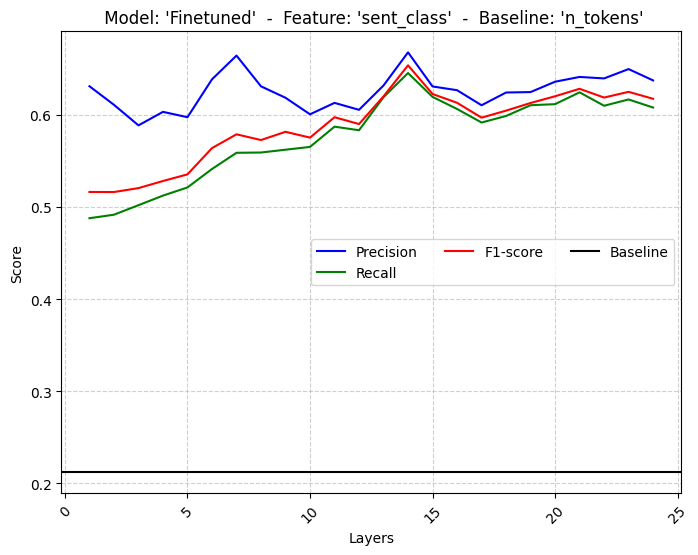

In [16]:
import matplotlib.pyplot as plt

# Extract the baseline
baseline_f1 = f1_df["Baseline"].iloc[0] 

# Transpose the data
precision_df = precision_df[layers].T
recall_df = recall_df[layers].T
f1_df = f1_df[layers].T

# Add a metric column
precision_df["Metric"] = "Precision"
recall_df["Metric"] = "Recall"
f1_df["Metric"] = "F1-score"

# Combine data
combined_df = pd.concat([precision_df, recall_df, f1_df])
combined_df["Layers"] = combined_df.index
plot_data = pd.melt(combined_df, ["Layers", "Metric"])

# Unique metrics
metrics = plot_data["Metric"].unique()
colors = {"Precision": "blue", "Recall": "green", "F1-score": "red"}

# Visualization with Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
for metric in metrics:
    subset = plot_data[plot_data["Metric"] == metric]
    ax.plot(subset["Layers"], subset["value"], label=metric, color=colors[metric])

ax.axhline(y=baseline_f1, color='black', label="F1-Baseline") # plot the baseline as a horizontal line
ax.legend(loc='best', ncol=3)
ax.set_title(" Model: 'Finetuned'  -  Feature: 'sent_class'  -  Baseline: 'n_tokens'")
ax.set_xlabel("Layers")
ax.set_ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
